# Import Library

In [1]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
import ast

import warnings
warnings.filterwarnings('ignore')

#visualization libraries
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_columns', 10000)

# Read Data

In [2]:
trx = pd.read_csv("../input/fashion-campus/transactions.csv")
cust = pd.read_csv("../input/fashion-campus/customer.csv")
products = pd.read_csv('../input/fashion-campus/product.csv', on_bad_lines='skip')
click = pd.read_csv('../input/fashion-campus/click_stream.csv')

# Normalize JSON - click_stream

In [3]:
click['event_metadata'] = click['event_metadata'].fillna('{}')

In [4]:
click['event_metadata'] = click['event_metadata'].apply(ast.literal_eval)

In [5]:
click_new = pd.concat([click.drop(['event_metadata'], axis=1), pd.json_normalize(click['event_metadata'])], axis=1)

In [6]:
click_new.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN


In [7]:
click_new.to_csv('click_stream_new.csv', index=False)

In [8]:
f = pd.read_csv('./click_stream_new.csv')
f.head()

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN


# Explode JSON - transactions

In [9]:
trx['product_metadata'] = trx['product_metadata'].apply(ast.literal_eval)

In [10]:
transaction_new = trx.explode('product_metadata')

In [11]:
transaction_new = pd.concat([transaction_new.drop(['product_metadata'], axis=1), transaction_new['product_metadata'].apply(pd.Series)], axis=1)

In [12]:
transaction_new.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753


In [13]:
transaction_new.to_csv('transaction_new.csv', index=False)

# Labelling

In [14]:
trx2 = transaction_new[transaction_new["payment_status"] == "Success"]
trx2.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753


In [15]:
cust_trx= pd.merge(cust[["customer_id","first_join_date"]],trx2[["customer_id","created_at"]], on = "customer_id", how = "left")
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaN
1,8193,2017-07-16,NaN
2,7279,2020-08-23,2020-08-23T12:53:12.916342Z
3,7279,2020-08-23,2020-08-23T12:53:12.916342Z
4,7279,2020-08-23,2020-08-31T13:34:59.916342Z
...,...,...,...
1250788,40573,2021-07-17,2021-10-21T15:43:07.139547Z
1250789,40573,2021-07-17,2022-01-23T19:01:48.139547Z
1250790,40573,2021-07-17,2022-03-11T19:03:09.139547Z
1250791,40573,2021-07-17,2022-04-27T20:00:55.139547Z


In [16]:
cust_trx["created_at"] = pd.to_datetime(cust_trx["created_at"])
cust_trx["first_join_date"] = pd.to_datetime(cust_trx["first_join_date"])

In [17]:
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaT
1,8193,2017-07-16,NaT
2,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
3,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
4,7279,2020-08-23,2020-08-31 13:34:59.916342+00:00
...,...,...,...
1250788,40573,2021-07-17,2021-10-21 15:43:07.139547+00:00
1250789,40573,2021-07-17,2022-01-23 19:01:48.139547+00:00
1250790,40573,2021-07-17,2022-03-11 19:03:09.139547+00:00
1250791,40573,2021-07-17,2022-04-27 20:00:55.139547+00:00


In [18]:
cust_trx['created_at'] = cust_trx['created_at'].dt.strftime('%Y-%m')
cust_trx['first_join_date'] = cust_trx['first_join_date'].dt.strftime('%Y-%m')

In [19]:
cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07,NaN
1,8193,2017-07,NaN
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


## Cust nvr trx

In [20]:
cust_nvr_trx = cust_trx[cust_trx["created_at"].isna()]
cust_nvr_trx.shape

(49758, 3)

sebanyak 49.758 (unique) customer tidak pernah transaksi sukses, sisanya yakni 50.242 customer (unique) pernah transaksi sukses

## Cust trx

In [21]:
cust_trx2 = cust_trx[~cust_trx["created_at"].isna()]
cust_trx2.shape

(1201035, 3)

In [22]:
cust_trx2

,customer_id,first_join_date,created_at
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
5,7279,2020-08,2020-09
6,7279,2020-08,2020-09
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


In [23]:
# groupkan berdasarkan customer_id dan created_at
cust_trx4 = cust_trx2.groupby(["customer_id","created_at"])['first_join_date'].first().reset_index()

In [24]:
cust_trx4

,customer_id,created_at,first_join_date
0,3,2018-08,2018-08
1,3,2018-09,2018-08
2,3,2018-10,2018-08
3,3,2018-11,2018-08
4,3,2018-12,2018-08
...,...,...,...
565536,99998,2020-07,2018-07
565537,99998,2021-01,2018-07
565538,99998,2021-07,2018-07
565539,99998,2022-01,2018-07


In [25]:
cust_trx4["created_at"] = pd.to_datetime(cust_trx4["created_at"])

In [26]:
size = cust_trx4.shape[0]
#temp = pd.DataFrame(columns=['A'])
a = []
for i in range (size-1) :
    # jika nilai pada baris ke i di kolom ke 0 == nilai pada baris selanjutnya kolom ke 0 (merupakan cust yg sama)
    if cust_trx4.iloc[i,0] == cust_trx4.iloc[i+1,0] :
        # maka (created_at pada bulan next - created_at pd bulan before) dibagi 1 bulan
        # ini untuk mencari jarak bulan transaksi sukses selanjutnya
        a.append((cust_trx4.iloc[i+1,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))
    # jika nilai pada baris ke i di kolom ke 0 != nilai pada baris selanjutnya kolom ke 0 (merupakan cust yg berbeda)
    else :
        # maka (created_at pada bulan now - created_at pd bulan now) dibagi 1 bulan
        # alias hasilnya 0, alias itu transaksi terakhir si cust tsb, atau bisa jd dia cuma transaksi sekali
        a.append((cust_trx4.iloc[i,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))

In [27]:
diff = pd.DataFrame(a, columns = ["diff"])
diff = round(diff)
diff.head()

,diff
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0


In [28]:
# langsung aja concat kalo emang jumlah rowsnya sama dan yakin dia emang seharusnya ada di row itu

cust_trx5 = pd.concat([cust_trx4, diff], axis=1)
cust_trx5["diff"] = cust_trx5["diff"].fillna(0)
cust_trx5

,customer_id,created_at,first_join_date,diff
0,3,2018-08-01,2018-08,1.0
1,3,2018-09-01,2018-08,1.0
2,3,2018-10-01,2018-08,1.0
3,3,2018-11-01,2018-08,1.0
4,3,2018-12-01,2018-08,2.0
...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0
565537,99998,2021-01-01,2018-07,6.0
565538,99998,2021-07-01,2018-07,6.0
565539,99998,2022-01-01,2018-07,0.0


disini, 1 berati jarak antara transaksi bulan sekarang dengan transaksi selanjutnya, berjarak 1 bulan. kalo 0 berati dah gada transaksi lagi (ga dipake), kalo 2,3dst berati ya jarak antara transaksi bulan ini dgn transaksi selanjutnya berjarak sesuai angka itu (churn)

In [29]:
def renovated(df) : 
    if df["diff"] == 1 : 
        return 0
    elif df["diff"] == 0 :
        return 2
    else :
        return 1

    
cust_trx5["flagging"] = cust_trx5.apply(renovated, axis =1 )

disni berati, ketika jarak transaksi sekarang dgn selanjutnya adalah 1 bulan, dia akan dilabeli 0, maka dia terhitung transaksi rutin. kalo jaraknya 0 bulan, dia akan dilabeli 2, dan ketika jarak ke transaksi selanjutnya adalah di atas 1 bulan, dia akan dilabeli 1 (churn)

In [30]:
cust_trx5

,customer_id,created_at,first_join_date,diff,flagging
0,3,2018-08-01,2018-08,1.0,0
1,3,2018-09-01,2018-08,1.0,0
2,3,2018-10-01,2018-08,1.0,0
3,3,2018-11-01,2018-08,1.0,0
4,3,2018-12-01,2018-08,2.0,1
...,...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0,1
565537,99998,2021-01-01,2018-07,6.0,1
565538,99998,2021-07-01,2018-07,6.0,1
565539,99998,2022-01-01,2018-07,0.0,2


In [31]:
final_flagging = cust_trx5[cust_trx5["flagging"] <= 1].drop(columns=['diff'])
final_flagging

,customer_id,created_at,first_join_date,flagging
0,3,2018-08-01,2018-08,0
1,3,2018-09-01,2018-08,0
2,3,2018-10-01,2018-08,0
3,3,2018-11-01,2018-08,0
4,3,2018-12-01,2018-08,1
...,...,...,...,...
565534,99998,2019-07-01,2018-07,1
565535,99998,2020-01-01,2018-07,1
565536,99998,2020-07-01,2018-07,1
565537,99998,2021-01-01,2018-07,1


nah disini, yang label 2 di drop, yang mana jika cust tsb cuma trans sekali selama ini atau itu adalah transaksi terakhirnya, maka dia tidak akan diikutkan ke dalam pembuatan untuk feature

In [32]:
final_flagging["flagging"].value_counts(normalize = True)

0    0.620106
1    0.379894
Name: flagging, dtype: float64

- 1 adalah nasabah churn
- 0 adalah nasabah yang trx rutin

# Feature Engineering

## 1. Traffic Source

In [33]:
# ini karena masing2 device pasti punya sessionnya masing-masing. tidak mungkin device yang berbeda
# memiliki session_id yang sama

click_traffic = click_new.groupby(['session_id'])[['traffic_source']].first().reset_index()

In [34]:
click_traffic

,session_id,traffic_source
0,00001f29-3ede-4445-95f0-0178934e32ba,MOBILE
1,00003eca-954b-4150-aee1-63fc62f395cf,MOBILE
2,0000425b-ddc8-4459-a240-6ba814dac132,MOBILE
3,00005746-17ec-449c-9c5c-699a3ea9304a,MOBILE
4,0000649b-9514-4600-979b-42166a798996,MOBILE
...,...,...
895198,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,WEB
895199,ffffd3d9-79db-459e-a427-388204a7aac7,MOBILE
895200,ffffdf8e-dea1-42bc-9839-7662675c0d38,MOBILE
895201,fffff7cf-2a18-4303-9c12-aa836ae3b543,MOBILE


In [35]:
trx_click = pd.merge(trx2[['created_at','customer_id','session_id']], click_traffic[['session_id','traffic_source']], on='session_id')

trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])
trx_click['created_at'] = trx_click['created_at'].dt.strftime('%Y-%m')
trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])

trx_click2 = trx_click.groupby(['customer_id','created_at','traffic_source']).count().reset_index()
trx_click2

,customer_id,created_at,traffic_source,session_id
0,3,2018-08-01,MOBILE,1
1,3,2018-09-01,MOBILE,1
2,3,2018-10-01,MOBILE,1
3,3,2018-11-01,MOBILE,1
4,3,2018-12-01,MOBILE,1
...,...,...,...,...
599993,99998,2020-07-01,MOBILE,2
599994,99998,2021-01-01,MOBILE,1
599995,99998,2021-07-01,MOBILE,1
599996,99998,2022-01-01,MOBILE,16


In [36]:
# trx_click2[trx_click2[['customer_id','created_at']].duplicated() == True]
trx_click2[trx_click2['customer_id'] == 99995]

,customer_id,created_at,traffic_source,session_id
599962,99995,2020-08-01,MOBILE,2
599963,99995,2020-09-01,MOBILE,6
599964,99995,2020-10-01,MOBILE,5
599965,99995,2020-11-01,MOBILE,2
599966,99995,2020-12-01,MOBILE,3
599967,99995,2021-01-01,MOBILE,2
599968,99995,2021-02-01,MOBILE,4
599969,99995,2021-03-01,MOBILE,3
599970,99995,2021-04-01,MOBILE,3
599971,99995,2021-05-01,MOBILE,3


In [37]:
# one hot encoding
trx_click3 = pd.get_dummies(trx_click2['traffic_source'])
trx_click3 = trx_click3.rename(columns = {
    'MOBILE' : 'mobile_used',
    'WEB' : 'web_used'
})
trx_click3

,mobile_used,web_used
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
599993,1,0
599994,1,0
599995,1,0
599996,1,0


In [38]:
# trx_click3 = trx_click2.pivot_table('session_id', ['customer_id','created_at'], 'traffic_source', aggfunc=len, fill_value=0).reset_index()
# trx_click3 = trx_click3.rename(columns = {
#     'MOBILE' : 'mobile_used',
#     'WEB' : 'web_used'
# })
trx_click4 = pd.concat([trx_click2, trx_click3], axis=1)
trx_click5 = trx_click4.groupby(['customer_id','created_at']).sum().reset_index()

trx_click5

,customer_id,created_at,session_id,mobile_used,web_used
0,3,2018-08-01,1,1,0
1,3,2018-09-01,1,1,0
2,3,2018-10-01,1,1,0
3,3,2018-11-01,1,1,0
4,3,2018-12-01,1,1,0
...,...,...,...,...,...
565534,99998,2020-07-01,2,1,0
565535,99998,2021-01-01,1,1,0
565536,99998,2021-07-01,1,1,0
565537,99998,2022-01-01,16,1,0


In [39]:
# trx_click5[trx_click5['mobile_used'] > 1]
trx_click5[trx_click5['web_used'] > 1]

,customer_id,created_at,session_id,mobile_used,web_used


In [40]:
# trx_click4 = final_flagging.merge(trx_click4, on=['customer_id','created_at'])
# trx_click4

trx_click6 = final_flagging.merge(trx_click5.iloc[:,[0,1,3,4]], on=['customer_id','created_at'], how='left')
trx_click6

,customer_id,created_at,first_join_date,flagging,mobile_used,web_used
0,3,2018-08-01,2018-08,0,1.0,0.0
1,3,2018-09-01,2018-08,0,1.0,0.0
2,3,2018-10-01,2018-08,0,1.0,0.0
3,3,2018-11-01,2018-08,0,1.0,0.0
4,3,2018-12-01,2018-08,1,1.0,0.0
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1.0,0.0
515295,99998,2020-01-01,2018-07,1,1.0,0.0
515296,99998,2020-07-01,2018-07,1,1.0,0.0
515297,99998,2021-01-01,2018-07,1,1.0,0.0


In [41]:
asess_1 = pd.crosstab(trx_click6["web_used"], trx_click6["flagging"], margins=True, margins_name="Total")
asess_1

flagging,0,1,Total
web_used,,,
0.0,267957,176132,444089
1.0,51583,19626,71209
Total,319540,195758,515298


In [42]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195758)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_1["%nonevent"] = asess_1.apply(nonevent, axis = 1)
asess_1["%event"] = asess_1.apply(event, axis = 1)

In [43]:
#Let's calculate WoE and save it to new a column WoE
asess_1["WoE"] = np.log(asess_1["%event"]/asess_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_1["IV"] = asess_1["WoE"]*(asess_1["%event"] - asess_1["%nonevent"])

#Let's sum IV
asess_1["IV"].sum() # Weak Predictor

0.03344570026681302

## 2. Quantity Item Add_to_Cart

In [44]:
click_add = click_new[click_new['event_name'] == 'ADD_TO_CART'][['session_id','quantity']].groupby('session_id').sum().reset_index()
click_add

,session_id,quantity
0,00001f29-3ede-4445-95f0-0178934e32ba,6.0
1,00003eca-954b-4150-aee1-63fc62f395cf,1.0
2,0000425b-ddc8-4459-a240-6ba814dac132,1.0
3,00005746-17ec-449c-9c5c-699a3ea9304a,6.0
4,0000649b-9514-4600-979b-42166a798996,3.0
...,...,...
872056,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,2.0
872057,ffffd3d9-79db-459e-a427-388204a7aac7,18.0
872058,ffffdf8e-dea1-42bc-9839-7662675c0d38,1.0
872059,fffff7cf-2a18-4303-9c12-aa836ae3b543,5.0


In [45]:
trx_add = pd.merge(trx2[['created_at','customer_id','session_id']], click_add, on='session_id')

trx_add['created_at'] = pd.to_datetime(trx_add["created_at"])
trx_add['created_at'] = trx_add['created_at'].dt.strftime('%Y-%m')
trx_add['created_at'] = pd.to_datetime(trx_add["created_at"])

trx_add2 = trx_add.groupby(['customer_id','created_at'])['quantity'].sum().reset_index()

In [46]:
trx_add2.describe()

,customer_id,quantity
count,565539.000000,565539.000000
mean,49868.677969,12.250031
std,28969.808969,47.946768
min,3.000000,1.000000
25%,24741.000000,1.000000
50%,49624.000000,3.000000
75%,74948.000000,8.000000
max,99999.000000,4117.000000


In [47]:
trx_add2[trx_add2['customer_id'] == 3]

,customer_id,created_at,quantity
0,3,2018-08-01,6.0
1,3,2018-09-01,3.0
2,3,2018-10-01,3.0
3,3,2018-11-01,3.0
4,3,2018-12-01,6.0
5,3,2019-02-01,1.0
6,3,2019-03-01,4.0
7,3,2019-04-01,2.0
8,3,2019-05-01,6.0
9,3,2019-06-01,13.0


In [48]:
trx_add3 = final_flagging.merge(trx_add2, on=['customer_id','created_at'], how='left')
trx_add3 = trx_add3.fillna(0)
trx_add3

,customer_id,created_at,first_join_date,flagging,quantity
0,3,2018-08-01,2018-08,0,6.0
1,3,2018-09-01,2018-08,0,3.0
2,3,2018-10-01,2018-08,0,3.0
3,3,2018-11-01,2018-08,0,3.0
4,3,2018-12-01,2018-08,1,6.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,2.0
515295,99998,2020-01-01,2018-07,1,1.0
515296,99998,2020-07-01,2018-07,1,6.0
515297,99998,2021-01-01,2018-07,1,1.0


In [49]:
trx_add3.describe()

,customer_id,flagging,quantity
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,12.330862
std,28972.061729,0.485361,48.238974
min,3.000000,0.000000,0.000000
25%,24742.000000,0.000000,1.000000
50%,49619.000000,0.000000,3.000000
75%,74951.000000,1.000000,8.000000
max,99998.000000,1.000000,4117.000000


In [50]:
def func(x):
    if x <= 2:
        return 1 #melakukan binning
    elif x <= 8:
        return 2
    else:
        return 3

trx_add3['add_to_cart_item'] = trx_add3['quantity'].apply(func)

In [51]:
trx_add3

,customer_id,created_at,first_join_date,flagging,quantity,add_to_cart_item
0,3,2018-08-01,2018-08,0,6.0,2
1,3,2018-09-01,2018-08,0,3.0,2
2,3,2018-10-01,2018-08,0,3.0,2
3,3,2018-11-01,2018-08,0,3.0,2
4,3,2018-12-01,2018-08,1,6.0,2
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,2.0,1
515295,99998,2020-01-01,2018-07,1,1.0,1
515296,99998,2020-07-01,2018-07,1,6.0,2
515297,99998,2021-01-01,2018-07,1,1.0,1


In [52]:
# trx_add3 = trx_add2.pivot_table('quantity', ['customer_id','created_at'], 'add_to_cart_item', aggfunc=sum, fill_value=0).reset_index()
# trx_add3['few_item_add'] = trx_add3['few_item_add'].apply(lambda x : 0 if x == 0 else 1)
# trx_add3['many_item_add'] = trx_add3['many_item_add'].apply(lambda x : 0 if x == 0 else 1)
# trx_add3['normal_item_add'] = trx_add3['normal_item_add'].apply(lambda x : 0 if x == 0 else 1)

In [53]:
asess_2 = pd.crosstab(trx_add3["add_to_cart_item"], trx_add3["flagging"], margins=True, margins_name="Total")
asess_2

flagging,0,1,Total
add_to_cart_item,,,
1,139719,89779,229498
2,98784,70018,168802
3,81037,35962,116999
Total,319540,195759,515299


In [54]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195758)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_2["%nonevent"] = asess_2.apply(nonevent, axis = 1)
asess_2["%event"] = asess_2.apply(event, axis = 1)

In [55]:
#Let's calculate WoE and save it to new a column WoE
asess_2["WoE"] = np.log(asess_2["%event"]/asess_2["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_2["IV"] = asess_2["WoE"]*(asess_2["%event"] - asess_2["%nonevent"])

#Let's sum IV
asess_2["IV"].sum() # Weak Predictor

0.030634958051771972

## 3. Promo amount

In [56]:
click_promo = click_new[click_new['event_name'] == 'ADD_PROMO'][['session_id','promo_amount']].groupby('session_id').sum().reset_index()
click_promo

,session_id,promo_amount
0,0000649b-9514-4600-979b-42166a798996,10288.0
1,0000f2fc-1875-4c88-9398-5b7386b14ca6,2365.0
2,0001434a-955b-41a9-80c1-12eed8a07701,5045.0
3,00014d8d-9ed6-4d01-9aa9-b4203736f296,8316.0
4,00016d24-4dd8-494f-bc62-4d55d4042b4f,4326.0
...,...,...
326530,ffff284a-9364-4296-a758-e3b0b4297f6d,4218.0
326531,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,3785.0
326532,ffffd3d9-79db-459e-a427-388204a7aac7,2221.0
326533,fffff7cf-2a18-4303-9c12-aa836ae3b543,10259.0


In [57]:
trx_promo = pd.merge(trx2[['created_at','customer_id','session_id']], click_promo, on='session_id')

trx_promo['created_at'] = pd.to_datetime(trx_promo["created_at"])
trx_promo['created_at'] = trx_promo['created_at'].dt.strftime('%Y-%m')
trx_promo['created_at'] = pd.to_datetime(trx_promo["created_at"])

trx_promo2 = trx_promo.groupby(['customer_id','created_at'])[['promo_amount']].sum().reset_index()

In [58]:
trx_promo2

,customer_id,created_at,promo_amount
0,3,2018-08-01,8073.0
1,3,2018-10-01,8828.0
2,3,2018-11-01,3415.0
3,3,2018-12-01,2645.0
4,3,2019-03-01,5161.0
...,...,...,...
265276,99998,2019-01-01,6039.0
265277,99998,2019-07-01,5670.0
265278,99998,2020-01-01,4912.0
265279,99998,2021-01-01,8569.0


In [59]:
trx_promo3 = final_flagging.merge(trx_promo2, on=['customer_id','created_at'], how='left')
trx_promo3 = trx_promo3.fillna(0)
trx_promo3

,customer_id,created_at,first_join_date,flagging,promo_amount
0,3,2018-08-01,2018-08,0,8073.0
1,3,2018-09-01,2018-08,0,0.0
2,3,2018-10-01,2018-08,0,8828.0
3,3,2018-11-01,2018-08,0,3415.0
4,3,2018-12-01,2018-08,1,2645.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670.0
515295,99998,2020-01-01,2018-07,1,4912.0
515296,99998,2020-07-01,2018-07,1,0.0
515297,99998,2021-01-01,2018-07,1,8569.0


In [60]:
trx_promo3.describe()

,customer_id,flagging,promo_amount
count,515299.000000,515299.000000,515299.00000
mean,49873.821358,0.379894,4438.26765
std,28972.061729,0.485361,9458.79004
min,3.000000,0.000000,0.00000
25%,24742.000000,0.000000,0.00000
50%,49619.000000,0.000000,0.00000
75%,74951.000000,1.000000,5805.00000
max,99998.000000,1.000000,353718.00000


In [61]:
def func(x):
    if x == 0:
        return 1 # melakukan binning
    elif x <= 10500:
        return 2
    else:
        return 3


trx_promo3['promo_used'] = trx_promo3['promo_amount'].apply(func)

In [62]:
trx_promo3

,customer_id,created_at,first_join_date,flagging,promo_amount,promo_used
0,3,2018-08-01,2018-08,0,8073.0,2
1,3,2018-09-01,2018-08,0,0.0,1
2,3,2018-10-01,2018-08,0,8828.0,2
3,3,2018-11-01,2018-08,0,3415.0,2
4,3,2018-12-01,2018-08,1,2645.0,2
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670.0,2
515295,99998,2020-01-01,2018-07,1,4912.0,2
515296,99998,2020-07-01,2018-07,1,0.0,1
515297,99998,2021-01-01,2018-07,1,8569.0,2


In [63]:
asess_3 = pd.crosstab(trx_promo3["promo_used"], trx_promo3["flagging"], margins=True, margins_name="Total")
asess_3

flagging,0,1,Total
promo_used,,,
1,154835,115059,269894
2,120934,68451,189385
3,43771,12249,56020
Total,319540,195759,515299


In [64]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_3["%nonevent"] = asess_3.apply(nonevent, axis = 1)
asess_3["%event"] = asess_3.apply(event, axis = 1)

In [65]:
#Let's calculate WoE and save it to new a column WoE
asess_3["WoE"] = np.log(asess_3["%event"]/asess_3["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_3["IV"] = asess_3["WoE"]*(asess_3["%event"] - asess_3["%nonevent"])

#Let's sum IV
asess_3["IV"].sum() # Weak Predictor

0.08050698251147215

## 4. Payment method

In [66]:
trx_method = trx2[['created_at','customer_id','payment_method']].copy()

trx_method['created_at'] = pd.to_datetime(trx_method["created_at"])
trx_method['created_at'] = trx_method['created_at'].dt.strftime('%Y-%m')
trx_method['created_at'] = pd.to_datetime(trx_method["created_at"])

trx_method2 = trx_method.groupby(['customer_id','created_at','payment_method']).count().reset_index()
trx_method2

,customer_id,created_at,payment_method
0,3,2018-08-01,Credit Card
1,3,2018-09-01,Credit Card
2,3,2018-10-01,Credit Card
3,3,2018-11-01,Credit Card
4,3,2018-12-01,Credit Card
...,...,...,...
636100,99998,2020-07-01,Credit Card
636101,99998,2021-01-01,Credit Card
636102,99998,2021-07-01,Debit Card
636103,99998,2022-01-01,Credit Card


In [67]:
trx_method2[trx_method2[['customer_id','created_at']].duplicated() == True]

,customer_id,created_at,payment_method
21,3,2020-05-01,LinkAja
34,3,2021-05-01,Gopay
46,3,2022-05-01,Debit Card
92,20,2021-11-01,OVO
94,20,2021-12-01,Debit Card
...,...,...,...
636077,99995,2021-06-01,Debit Card
636083,99995,2021-11-01,Debit Card
636085,99995,2021-12-01,Gopay
636089,99995,2022-03-01,OVO


In [68]:
# one hot encoding
trx_method3 = pd.get_dummies(trx_method2['payment_method'])
trx_method3 = trx_method3.rename(columns = {
    'Debit Card' : 'debit_card',
    'Credit Card' : 'credit_card',
    'Gopay' : 'gopay',
    'LinkAja' : 'linkAja',
    'OVO' : 'ovo'
})
trx_method3

,credit_card,debit_card,gopay,linkAja,ovo
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
636100,1,0,0,0,0
636101,1,0,0,0,0
636102,0,1,0,0,0
636103,1,0,0,0,0


In [69]:
trx_method4 = pd.concat([trx_method2, trx_method3], axis=1)
trx_method5 = trx_method4.groupby(['customer_id','created_at']).sum().reset_index()

trx_method5

,customer_id,created_at,credit_card,debit_card,gopay,linkAja,ovo
0,3,2018-08-01,1,0,0,0,0
1,3,2018-09-01,1,0,0,0,0
2,3,2018-10-01,1,0,0,0,0
3,3,2018-11-01,1,0,0,0,0
4,3,2018-12-01,1,0,0,0,0
...,...,...,...,...,...,...,...
565536,99998,2020-07-01,1,0,0,0,0
565537,99998,2021-01-01,1,0,0,0,0
565538,99998,2021-07-01,0,1,0,0,0
565539,99998,2022-01-01,1,0,0,0,0


In [70]:
trx_method6 = final_flagging.merge(trx_method5, on=['customer_id','created_at'], how='left')
trx_method6

,customer_id,created_at,first_join_date,flagging,credit_card,debit_card,gopay,linkAja,ovo
0,3,2018-08-01,2018-08,0,1,0,0,0,0
1,3,2018-09-01,2018-08,0,1,0,0,0,0
2,3,2018-10-01,2018-08,0,1,0,0,0,0
3,3,2018-11-01,2018-08,0,1,0,0,0,0
4,3,2018-12-01,2018-08,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1,0,0,0,0
515295,99998,2020-01-01,2018-07,1,0,1,0,0,0
515296,99998,2020-07-01,2018-07,1,1,0,0,0,0
515297,99998,2021-01-01,2018-07,1,1,0,0,0,0


## 5. shipment fee

In [71]:
trx_shipment = trx2[['created_at','customer_id','shipment_fee']].copy()

trx_shipment['created_at'] = pd.to_datetime(trx_shipment["created_at"])
trx_shipment['created_at'] = trx_shipment['created_at'].dt.strftime('%Y-%m')
trx_shipment['created_at'] = pd.to_datetime(trx_shipment["created_at"])

trx_shipment2 = trx_shipment.groupby(['customer_id','created_at']).sum().reset_index()
trx_shipment2

,customer_id,created_at,shipment_fee
0,3,2018-08-01,0
1,3,2018-09-01,10000
2,3,2018-10-01,10000
3,3,2018-11-01,0
4,3,2018-12-01,10000
...,...,...,...
565536,99998,2020-07-01,20000
565537,99998,2021-01-01,10000
565538,99998,2021-07-01,0
565539,99998,2022-01-01,160000


In [72]:
trx_shipment3 = final_flagging.merge(trx_shipment2, on=['customer_id','created_at'], how='left')
trx_shipment3

,customer_id,created_at,first_join_date,flagging,shipment_fee
0,3,2018-08-01,2018-08,0,0
1,3,2018-09-01,2018-08,0,10000
2,3,2018-10-01,2018-08,0,10000
3,3,2018-11-01,2018-08,0,0
4,3,2018-12-01,2018-08,1,10000
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,10000
515295,99998,2020-01-01,2018-07,1,0
515296,99998,2020-07-01,2018-07,1,20000
515297,99998,2021-01-01,2018-07,1,10000


In [73]:
trx_shipment3.describe()

,customer_id,flagging,shipment_fee
count,515299.000000,515299.000000,5.152990e+05
mean,49873.821358,0.379894,1.970034e+04
std,28972.061729,0.485361,3.275937e+04
min,3.000000,0.000000,0.000000e+00
25%,24742.000000,0.000000,1.000000e+04
50%,49619.000000,0.000000,1.000000e+04
75%,74951.000000,1.000000,2.000000e+04
max,99998.000000,1.000000,1.640000e+06


In [74]:
def func(x):
    if x <= 10000:
        return 1 # melakukan binning
    elif x <= 20000:
        return 2
    else:
        return 3


trx_shipment3['shipments_fee'] = trx_shipment3['shipment_fee'].apply(func)

In [75]:
asess_5 = pd.crosstab(trx_shipment3["shipments_fee"], trx_shipment3["flagging"], margins=True, margins_name="Total")
asess_5

flagging,0,1,Total
shipments_fee,,,
1,172467,150255,322722
2,54078,20040,74118
3,92995,25464,118459
Total,319540,195759,515299


In [76]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_5["%nonevent"] = asess_5.apply(nonevent, axis = 1)
asess_5["%event"] = asess_5.apply(event, axis = 1)

In [77]:
#Let's calculate WoE and save it to new a column WoE
asess_5["WoE"] = np.log(asess_5["%event"]/asess_5["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_5["IV"] = asess_5["WoE"]*(asess_5["%event"] - asess_5["%nonevent"])

#Let's sum IV
asess_5["IV"].sum() # Medium Predictor

0.24344309319640933

In [78]:
trx_shipment3

,customer_id,created_at,first_join_date,flagging,shipment_fee,shipments_fee
0,3,2018-08-01,2018-08,0,0,1
1,3,2018-09-01,2018-08,0,10000,1
2,3,2018-10-01,2018-08,0,10000,1
3,3,2018-11-01,2018-08,0,0,1
4,3,2018-12-01,2018-08,1,10000,1
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,10000,1
515295,99998,2020-01-01,2018-07,1,0,1
515296,99998,2020-07-01,2018-07,1,20000,2
515297,99998,2021-01-01,2018-07,1,10000,1


## 6. shipment date limit

In [79]:
trx_datelimit = trx2[['created_at','customer_id','shipment_date_limit']].copy()

trx_datelimit['created_at'] = pd.to_datetime(trx_datelimit["created_at"])
trx_datelimit['shipment_date_limit'] = pd.to_datetime(trx_datelimit["shipment_date_limit"])

trx_datelimit['diff_datelimit'] = trx_datelimit['shipment_date_limit'] - trx_datelimit['created_at']

trx_datelimit['created_at'] = trx_datelimit['created_at'].dt.strftime('%Y-%m')
trx_datelimit['created_at'] = pd.to_datetime(trx_datelimit["created_at"])

trx_datelimit2 = trx_datelimit.groupby(['customer_id','created_at'])[['diff_datelimit']].mean().reset_index()
trx_datelimit2

,customer_id,created_at,diff_datelimit
0,3,2018-08-01,1 days 10:14:11.973051
1,3,2018-09-01,3 days 00:32:02.888480
2,3,2018-10-01,5 days 10:19:03.419877
3,3,2018-11-01,3 days 09:56:18.435177
4,3,2018-12-01,3 days 01:42:02.245432
...,...,...,...
565536,99998,2020-07-01,4 days 19:30:47.205880
565537,99998,2021-01-01,1 days 00:52:13.840735
565538,99998,2021-07-01,2 days 03:36:13.194951
565539,99998,2022-01-01,1 days 17:13:40.615007


In [80]:
trx_datelimit2.describe()

,customer_id,diff_datelimit
count,565541.000000,565541
mean,49868.684955,3 days 12:26:44.867104319
std,28969.757982,1 days 08:12:25.663020245
min,3.000000,1 days 00:00:02.200453
25%,24741.000000,2 days 10:29:17.947286400
50%,49624.000000,3 days 12:28:55.253620
75%,74948.000000,4 days 14:21:41.798299
max,99999.000000,6 days 00:59:59.332085


In [81]:
from datetime import datetime, timedelta

# menentukan kategori
def func(row):
    if row <= timedelta(days = 2):
        return 1
    elif row <= timedelta(days = 4):
        return 2
    elif row <= timedelta(days = 5):
        return 3
    else:
        return 4

trx_datelimit2['diff_datelimits'] = trx_datelimit2['diff_datelimit'].apply(func)

In [82]:
trx_datelimit3 = final_flagging.merge(trx_datelimit2, on=['customer_id','created_at'])
trx_datelimit3

,customer_id,created_at,first_join_date,flagging,diff_datelimit,diff_datelimits
0,3,2018-08-01,2018-08,0,1 days 10:14:11.973051,1
1,3,2018-09-01,2018-08,0,3 days 00:32:02.888480,2
2,3,2018-10-01,2018-08,0,5 days 10:19:03.419877,4
3,3,2018-11-01,2018-08,0,3 days 09:56:18.435177,2
4,3,2018-12-01,2018-08,1,3 days 01:42:02.245432,2
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,3 days 01:25:27.973391,2
515295,99998,2020-01-01,2018-07,1,2 days 05:33:26.784554,2
515296,99998,2020-07-01,2018-07,1,4 days 19:30:47.205880,3
515297,99998,2021-01-01,2018-07,1,1 days 00:52:13.840735,1


In [83]:
asess_6 = pd.crosstab(trx_datelimit3["diff_datelimits"], trx_datelimit3["flagging"], margins=True, margins_name="Total")
asess_6

flagging,0,1,Total
diff_datelimits,,,
1,44036,37578,81614
2,156875,78612,235487
3,71078,39307,110385
4,47551,40262,87813
Total,319540,195759,515299


In [84]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_6["%nonevent"] = asess_6.apply(nonevent, axis = 1)
asess_6["%event"] = asess_6.apply(event, axis = 1)


In [85]:
#Let's calculate WoE and save it to new a column WoE
asess_6["WoE"] = np.log(asess_6["%event"]/asess_6["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_6["IV"] = asess_6["WoE"]*(asess_6["%event"] - asess_6["%nonevent"])

#Let's sum IV
asess_6["IV"].sum() # Weak Predictor

0.05651782273549739

## 7. click item detail 

In [86]:
click_new['event_name'].value_counts()

CLICK          2498038
HOMEPAGE       2487126
ADD_TO_CART    1937157
SCROLL         1663571
ITEM_DETAIL    1290396
SEARCH         1173266
BOOKING         852582
PROMO_PAGE      604931
ADD_PROMO       326535
Name: event_name, dtype: int64

In [87]:
click_item = click_new[click_new['event_name'] == 'ITEM_DETAIL'][['session_id']]
click_item2 = trx2.iloc[:,[0,1,3]].merge(click_item, on='session_id')

click_item2['created_at'] = pd.to_datetime(click_item2["created_at"])
click_item2['created_at'] = click_item2['created_at'].dt.strftime('%Y-%m')
click_item2['created_at'] = pd.to_datetime(click_item2["created_at"])

In [88]:
click_item3 = click_item2.groupby(['customer_id','created_at']).count().reset_index()
click_item3 = click_item3.rename(columns={
    'session_id' : 'click_detail_item'
})
click_item3

,customer_id,created_at,click_detail_item
0,3,2018-10-01,2
1,3,2018-11-01,2
2,3,2018-12-01,1
3,3,2019-02-01,1
4,3,2019-03-01,2
...,...,...,...
363257,99998,2019-07-01,27
363258,99998,2021-01-01,2
363259,99998,2021-07-01,2
363260,99998,2022-01-01,32


In [89]:
click_item4 = final_flagging.merge(click_item3, on=['customer_id','created_at'], how='left')
click_item4 = click_item4.fillna(0)
click_item4

,customer_id,created_at,first_join_date,flagging,click_detail_item
0,3,2018-08-01,2018-08,0,0.0
1,3,2018-09-01,2018-08,0,0.0
2,3,2018-10-01,2018-08,0,2.0
3,3,2018-11-01,2018-08,0,2.0
4,3,2018-12-01,2018-08,1,1.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,27.0
515295,99998,2020-01-01,2018-07,1,0.0
515296,99998,2020-07-01,2018-07,1,0.0
515297,99998,2021-01-01,2018-07,1,2.0


In [90]:
click_item4.describe()

,customer_id,flagging,click_detail_item
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,3.282605
std,28972.061729,0.485361,7.314569
min,3.000000,0.000000,0.000000
25%,24742.000000,0.000000,0.000000
50%,49619.000000,0.000000,1.000000
75%,74951.000000,1.000000,4.000000
max,99998.000000,1.000000,420.000000


In [91]:
# menentukan kategori
def func(row):
    if row <= 1:
        return 1
    elif row <= 4:
        return 2
    else:
        return 3

click_item4['click_detail_items'] = click_item4['click_detail_item'].apply(func)

In [92]:
asess_7 = pd.crosstab(click_item4["click_detail_items"], click_item4["flagging"], margins=True, margins_name="Total")
asess_7

flagging,0,1,Total
click_detail_items,,,
1,145788,136455,282243
2,89471,43268,132739
3,84281,16036,100317
Total,319540,195759,515299


In [93]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_7["%nonevent"] = asess_7.apply(nonevent, axis = 1)
asess_7["%event"] = asess_7.apply(event, axis = 1)

In [94]:
#Let's calculate WoE and save it to new a column WoE
asess_7["WoE"] = np.log(asess_7["%event"]/asess_7["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_7["IV"] = asess_7["WoE"]*(asess_7["%event"] - asess_7["%nonevent"])

#Let's sum IV
asess_7["IV"].sum() # strong Predictor

0.32864292394681305

## 8. click homepage

In [95]:
click_home = click_new[click_new['event_name'] == 'HOMEPAGE'][['session_id']]
click_home2 = trx2.iloc[:,[0,1,3]].merge(click_home, on='session_id')

click_home2['created_at'] = pd.to_datetime(click_home2["created_at"])
click_home2['created_at'] = click_home2['created_at'].dt.strftime('%Y-%m')
click_home2['created_at'] = pd.to_datetime(click_home2["created_at"])

In [96]:
click_home3 = click_home2.groupby(['customer_id','created_at']).count().reset_index()
click_home3 = click_home3.rename(columns={
    'session_id' : 'click_homepage'
})
click_home3

,customer_id,created_at,click_homepage
0,3,2018-08-01,1
1,3,2018-09-01,1
2,3,2018-10-01,4
3,3,2018-11-01,1
4,3,2018-12-01,3
...,...,...,...
565534,99998,2020-07-01,2
565535,99998,2021-01-01,3
565536,99998,2021-07-01,2
565537,99998,2022-01-01,16


In [97]:
click_home4 = final_flagging.merge(click_home3, on=['customer_id','created_at'], how='left')
click_home4 = click_home4.fillna(0)
click_home4

,customer_id,created_at,first_join_date,flagging,click_homepage
0,3,2018-08-01,2018-08,0,1.0
1,3,2018-09-01,2018-08,0,1.0
2,3,2018-10-01,2018-08,0,4.0
3,3,2018-11-01,2018-08,0,1.0
4,3,2018-12-01,2018-08,1,3.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,158.0
515295,99998,2020-01-01,2018-07,1,1.0
515296,99998,2020-07-01,2018-07,1,2.0
515297,99998,2021-01-01,2018-07,1,3.0


In [98]:
click_home4.describe()

,customer_id,flagging,click_homepage
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,6.133404
std,28972.061729,0.485361,15.005130
min,3.000000,0.000000,0.000000
25%,24742.000000,0.000000,1.000000
50%,49619.000000,0.000000,3.000000
75%,74951.000000,1.000000,6.000000
max,99998.000000,1.000000,1875.000000


In [99]:
# menentukan kategori
def func(row):
    if row <= 1:
        return 1
    elif row <= 5:
        return 2
    else:
        return 3

click_home4['click_homepages'] = click_home4['click_homepage'].apply(func)

In [100]:
asess_8 = pd.crosstab(click_home4["click_homepages"], click_home4["flagging"], margins=True, margins_name="Total")
asess_8

flagging,0,1,Total
click_homepages,,,
1,63951,86566,150517
2,133948,87294,221242
3,121641,21899,143540
Total,319540,195759,515299


In [101]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
asess_8["%nonevent"] = asess_8.apply(nonevent, axis = 1)
asess_8["%event"] = asess_8.apply(event, axis = 1)

In [102]:
#Let's calculate WoE and save it to new a column WoE
asess_8["WoE"] = np.log(asess_8["%event"]/asess_8["%nonevent"])

# Let's calculate IV and save it to new a column IV
asess_8["IV"] = asess_8["WoE"]*(asess_8["%event"] - asess_8["%nonevent"])

#Let's sum IV
asess_8["IV"].sum() # strong Predictor

0.5227570940503958

# Feature Selection

In [103]:
feature_all = trx_click6.merge(trx_add3.drop(columns=['quantity']), on=['customer_id','created_at','first_join_date','flagging'])
feature_all = feature_all.merge(trx_promo3.drop(columns=['promo_amount']), on=['customer_id','created_at','first_join_date','flagging'])
# feature_all = feature_all.merge(trx_method6, on=['customer_id','created_at','first_join_date','flagging'])
feature_all = feature_all.merge(trx_shipment3.drop(columns=['shipment_fee']), on=['customer_id','created_at','first_join_date','flagging'])
feature_all = feature_all.merge(trx_datelimit3.drop(columns=['diff_datelimit']), on=['customer_id','created_at','first_join_date','flagging'])
feature_all = feature_all.merge(click_item4.drop(columns=['click_detail_item']), on=['customer_id','created_at','first_join_date','flagging'])
feature_all = feature_all.merge(click_home4.drop(columns=['click_homepage']), on=['customer_id','created_at','first_join_date','flagging'])

feature_all = feature_all.fillna(0)

In [104]:
feature_all.isna().sum()

customer_id           0
created_at            0
first_join_date       0
flagging              0
mobile_used           0
web_used              0
add_to_cart_item      0
promo_used            0
shipments_fee         0
diff_datelimits       0
click_detail_items    0
click_homepages       0
dtype: int64

In [105]:
X = feature_all.iloc[:,4:]
y = feature_all[["flagging"]]

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (360709, 8)
Jumlah data testing:  (154590, 8)


In [107]:
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [108]:
iv_df = X_train.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

,Feature,iv
0,mobile_used,0.022457
1,web_used,0.032109
2,add_to_cart_item,0.030047
3,promo_used,0.079968
4,shipments_fee,0.242014
5,diff_datelimits,0.058132
6,click_detail_items,0.327078
7,click_homepages,0.520052


# Modelling

In [109]:
selected_features = ['mobile_used','web_used','add_to_cart_item','promo_used','shipments_fee','diff_datelimits','click_detail_items','click_homepages']

In [110]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42)
}

In [111]:
result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])

y_test = y_test.astype(int)

In [112]:
for key, classifier in classifiers.items():
    classifier.fit(X_train[selected_features], y_train)
    y_predict = classifier.predict(X_test[selected_features])
    
    yproba = classifier.predict_proba(X_test[selected_features])[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

0:	learn: 0.6426899	total: 141ms	remaining: 35.2s
25:	learn: 0.5552855	total: 3.9s	remaining: 33.6s
50:	learn: 0.5549550	total: 6.41s	remaining: 25s
75:	learn: 0.5548065	total: 11.4s	remaining: 26s
100:	learn: 0.5547428	total: 23.6s	remaining: 34.8s
125:	learn: 0.5547216	total: 35.9s	remaining: 35.3s
150:	learn: 0.5547115	total: 48s	remaining: 31.5s
175:	learn: 0.5547050	total: 1m	remaining: 25.3s
200:	learn: 0.5547006	total: 1m 12s	remaining: 17.7s
225:	learn: 0.5546977	total: 1m 24s	remaining: 9.01s
249:	learn: 0.5546957	total: 1m 36s	remaining: 0us


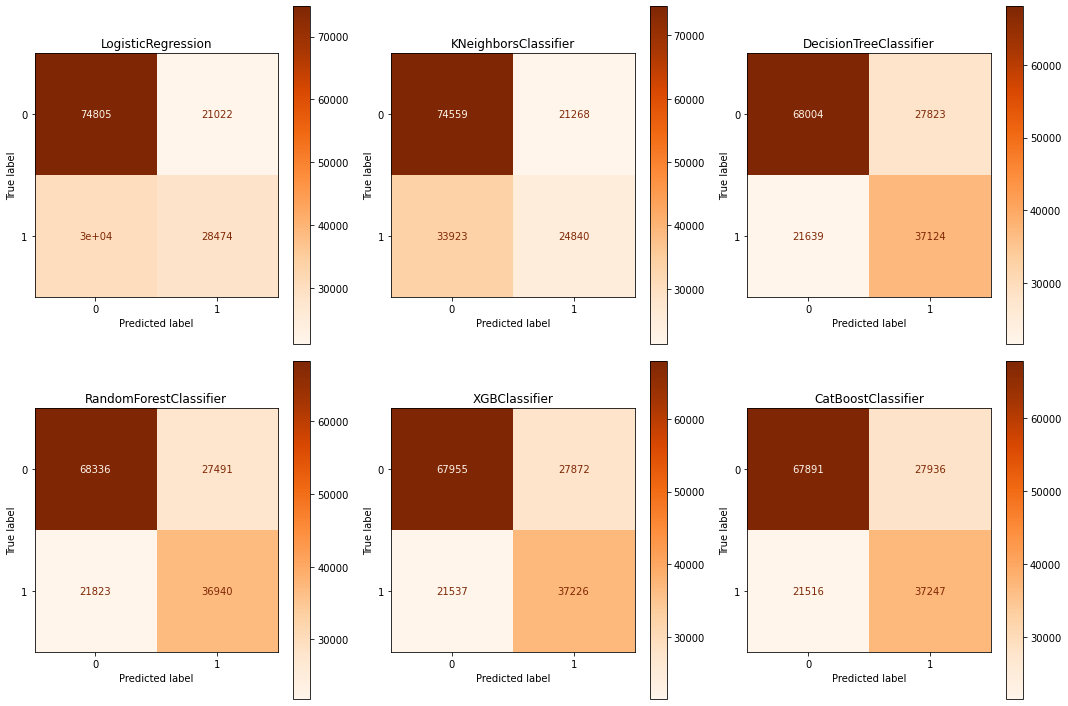

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test[selected_features], 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

# Performance

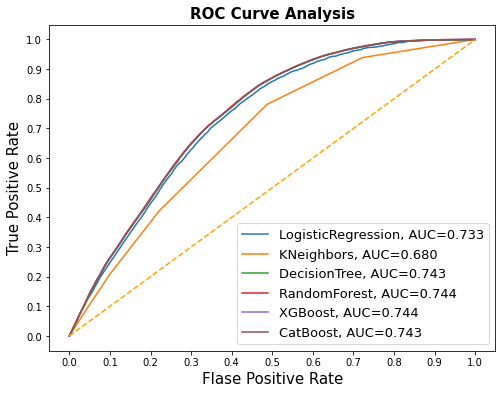

In [114]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [115]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.668083,0.659900,0.668083,0.661532
KNeighbors,0.642985,0.630823,0.642985,0.632501
DecisionTree,0.680044,0.687525,0.680044,0.682707
RandomForest,0.681001,0.687771,0.681001,0.683479
XGBoost,0.680387,0.688070,0.680387,0.683097
CatBoost,0.680109,0.687913,0.680109,0.682850
